Processing image: image.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


/var/folders/t4/9mx16sps4dj1sqdw_xpqfhk80000gn/T/ipykernel_49454/2513045287.py:67: RuntimeWarning: invalid value encountered in divide
  feature /= feature.std()
/var/folders/t4/9mx16sps4dj1sqdw_xpqfhk80000gn/T/ipykernel_49454/2513045287.py:70: RuntimeWarning: invalid value encountered in cast
  feature = np.clip(feature, 0, 255).astype("uint8")


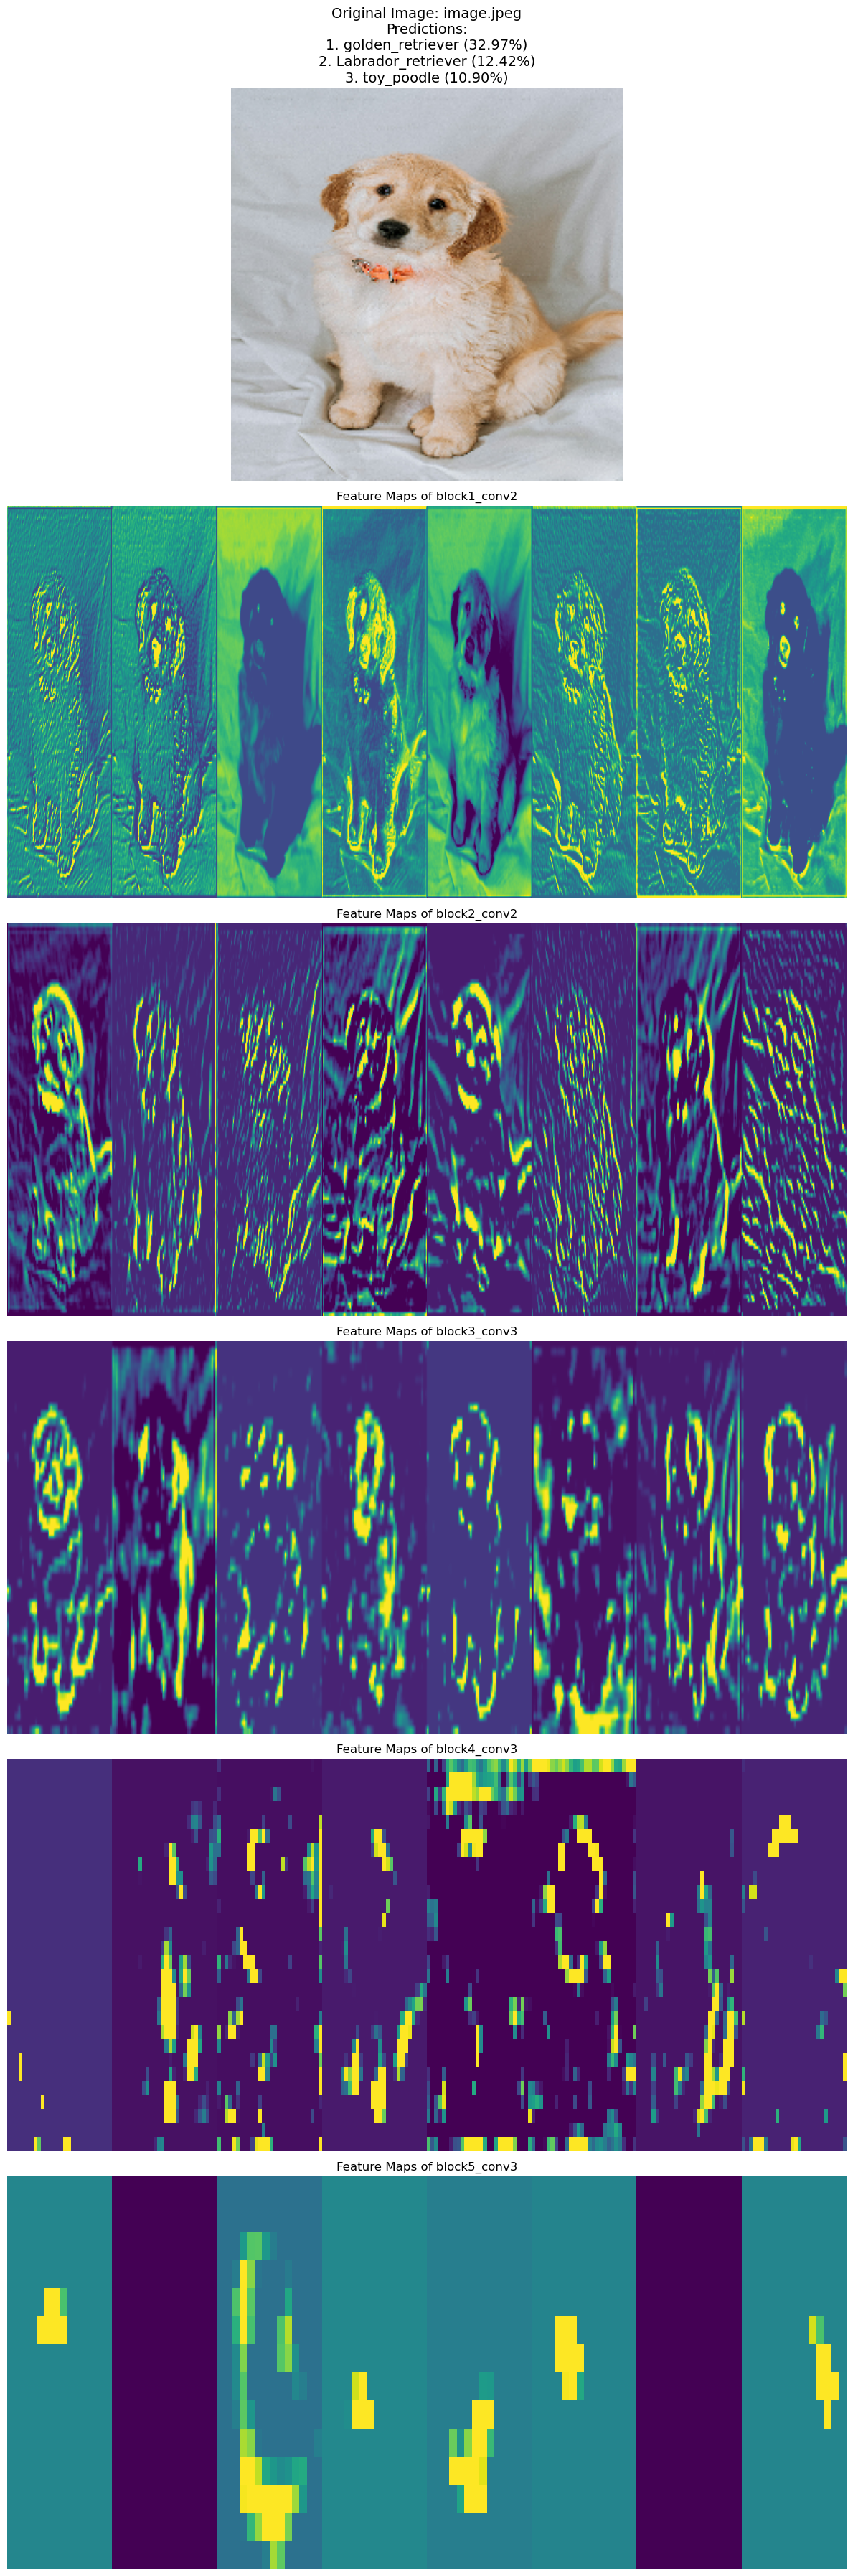

In [9]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

# Load the VGG16 model with pretrained weights, including the top layer for predictions
model_with_top = VGG16(weights="imagenet", include_top=True)

# Specify the path to the input image
img_path = 'image.jpeg'  # Replace with the path to your image file
img_name = os.path.basename(img_path)  # Extract the image file name

# Print the image file name
print(f"Processing image: {img_name}")

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # VGG16 target size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict the class of the image
predictions = model_with_top.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=3)[0]  # Get the top 3 predictions

# Format the predictions to display in the plot title
predicted_text = (
    f'Predictions:\n'
    f'1. {decoded_predictions[0][1]} ({decoded_predictions[0][2] * 100:.2f}%)\n'
    f'2. {decoded_predictions[1][1]} ({decoded_predictions[1][2] * 100:.2f}%)\n'
    f'3. {decoded_predictions[2][1]} ({decoded_predictions[2][2] * 100:.2f}%)'
)

# Layers to visualize feature maps (from VGG16 model)
layers_to_visualize = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
layer_outputs = [model_with_top.get_layer(layer_name).output for layer_name in layers_to_visualize]

# Define a model that outputs the feature maps for the specified layers
intermediate_model = Model(inputs=model_with_top.input, outputs=layer_outputs)
feature_maps = intermediate_model.predict(img_array)

# Function to plot both the original image and feature maps for multiple layers
def plot_image_and_feature_maps_for_layers(feature_maps, img, img_name, predicted_text, layer_names):
    num_layers = len(feature_maps)
    fig, axes = plt.subplots(num_layers + 1, 1, figsize=(12, (num_layers + 1) * 6))
    
    # Display the original image with predictions at the top
    axes[0].imshow(img)
    axes[0].set_title(f'Original Image: {img_name}\n{predicted_text}', fontsize=14)
    axes[0].axis('off')

    for layer_idx, feature_map in enumerate(feature_maps):
        layer_name = layer_names[layer_idx]
        num_features = feature_map.shape[-1]  # Number of filters in the layer
        size = feature_map.shape[1]           # Spatial size of feature maps
        display_grid = np.zeros((size, size * min(num_features, 8)))  # Grid for visualization

        # Arrange feature maps into a grid of 8 columns
        for i in range(min(num_features, 8)):  # Limiting to 8 features per layer for display
            feature = feature_map[0, :, :, i]
            feature -= feature.mean()  # Normalize for better visualization
            feature /= feature.std()
            feature *= 64
            feature += 128
            feature = np.clip(feature, 0, 255).astype("uint8")
            display_grid[:, i * size: (i + 1) * size] = feature

        # Plot the feature maps for each layer
        ax = axes[layer_idx + 1]
        ax.imshow(display_grid, aspect='auto', cmap="viridis")
        ax.set_title(f'Feature Maps of {layer_name}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the original image, predicted label, and feature maps for selected layers
plot_image_and_feature_maps_for_layers(feature_maps, img, img_name, predicted_text, layers_to_visualize)
